# Adaboost ou XGBoost ?

Two popular boosting algorithms are Adaboost and XGBoost, the goal of this exercise is to apply them both to a prediction problem and evaluate their performance with different base models. The dataset we will use is that of Airbnb listings in Seattle, the goal is to predict the price per night of the listing.
There will be quite a lot of preprocessing to do in this exercise as well as some interesting exploratory analysis and visualization. Do not hesitate to deviate from the questions to explore the data further.

1. Let's import the usual librairies.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import ast
from datetime import datetime
from sklearn.impute import KNNImputer

from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor 


2. Import the ```listings.csv``` dataset from s3 using the following link s3://full-stack-bigdata-datasets/Machine Learning Supervisé/Boosting/listings.csv

In [2]:
listings = pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/Boosting/listings.csv")
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

3. There are a lot of columns in this dataset. Display the dataset info.

In [3]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

4. Let's proceed to some visualization, first display the distribution of the price variable. You will have to preprocess it as it is not in a numerical format.

In [4]:
listings['price']

0        $85.00
1       $150.00
2       $975.00
3       $100.00
4       $450.00
         ...   
3813    $359.00
3814     $79.00
3815     $93.00
3816     $99.00
3817     $87.00
Name: price, Length: 3818, dtype: object

C:\Users\Berenger\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price2', ylabel='Density'>

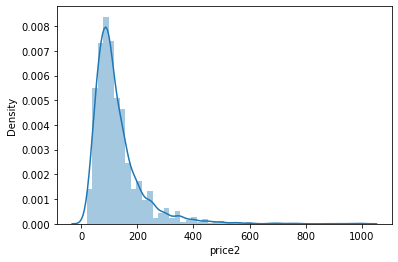

In [5]:
# remove first character of column price within a new price2 column and remove the , whenever there is one so we can use it for visualisation
listings["price2"] = listings.price.apply(lambda x: x[1:])
listings["price2"] = listings.price2.str.replace(",","").astype(float)
sns.distplot(listings.price2)

5. The distribution of the target variable is skewed towards high values (this is a very usual situation when working with prices, many items are around the average price range and the higher the price, the fewer items there are). A standard way of working with such variables is to change the scale using the log function so the distribution becomes evenly distributed.
Create a price_log variable that's equal to log(price)

In [6]:
listings["price_log"] = np.log10(listings.price2)
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month,price2,price_log
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,97.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000,3818.000000,3818.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,1.735394,854.618557,1.672603,2.369303,780.447617,16.786276,36.814825,58.082504,244.772656,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919,127.976166,2.032163
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,1.139480,671.404893,1.311040,16.305902,1683.589007,12.173637,23.337541,34.063845,126.772526,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348,90.250022,0.245605
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000,20.000000,1.301030
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000,1.000000,60.000000,2.000000,13.000000,28.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000,75.000000,1.875061
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,1.000000,750.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000,100.000000,2.000000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000,150.000000,2.176091
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,15.000000,3000.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000,1000.000000,3.000000


C:\Users\Berenger\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price_log', ylabel='Density'>

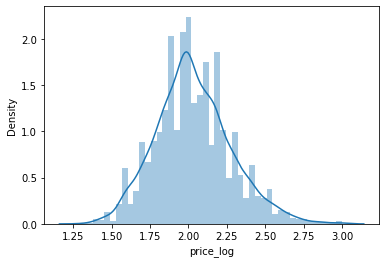

In [7]:
sns.distplot(listings.price_log)

The distribution looks a lot better for prediction purposes after the log transformation!

6. Visualize the price against the following variables : 

- ```room type```
- ```beds```
- ```property type```

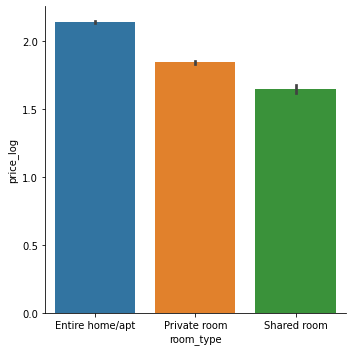

In [8]:
sns.catplot(x="room_type", y="price_log", data=listings, kind="bar")

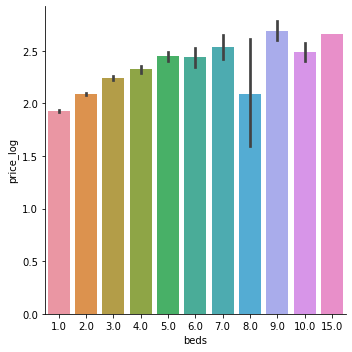

In [9]:
sns.catplot(x="beds", y="price_log", data=listings, kind="bar")

In [10]:
listings[listings.beds==8]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,price2,price_log
935,7344117,https://www.airbnb.com/rooms/7344117,20160104002432,2016-01-04,"SUPER TALL, 5-Level Loft, 2200sf","5-level, bright & modern loft with 20' ceiling...",Welcome to my 5-story loft located about a lit...,"5-level, bright & modern loft with 20' ceiling...",none,We are located at 1820 E Yesler Way in Seattle...,There is one compact parking space available i...,"Yep, Seattle is hilly. No worries - the #27 Me...",https://a1.muscache.com/ac/pictures/93184318/2...,https://a1.muscache.com/im/pictures/93184318/2...,https://a1.muscache.com/ac/pictures/93184318/2...,https://a1.muscache.com/ac/pictures/93184318/2...,38474213,https://www.airbnb.com/users/show/38474213,Jessie,2015-07-14,"Seattle, Washington, United States",NaN,within an hour,92%,100%,t,https://a0.muscache.com/ac/users/38474213/prof...,https://a0.muscache.com/ac/users/38474213/prof...,Minor,1.0,1.0,"['email', 'phone', 'linkedin', 'reviews', 'jum...",t,t,"East Yesler Way, Seattle, WA 98122, United States",Minor,Minor,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.602301,-122.307173,t,Loft,Entire home/apt,10,2.5,2.0,8.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,$425.00,NaN,NaN,NaN,$85.00,4,$25.00,1,1125,today,t,21,49,78,188,2016-01-04,32,2015-07-20,2015-12-30,96.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,t,strict,f,f,1,5.68,425.0,2.628389
997,8424532,https://www.airbnb.com/rooms/8424532,20160104002432,2016-01-04,Ideal Home for Small Reunions,Lge home- corner lot -walking distance to Lak...,NaN,Lge home- corner lot -walking distance to Lak...,none,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/107150138/...,https://a0.muscache.com/im/pictures/107150138/...,https://a0.muscache.com/ac/pictures/107150138/...,https://a0.muscache.com/ac/pictures/107150138/...,658155,https://www.airbnb.com/users/show/658155,Joe,2011-06-02,"Seattle, Washington, United States",Addicted renovator of homes. Love helping peo...,within an hour,100%,100%,t,https://a2.muscache.com/ac/users/658155/profil...,https://a2.muscache.com/ac/users/658155/profil...,Capitol Hill,13.0,13.0,"['email', 'phone', 'reviews', 'kba']",t,t,"32nd Avenue, Seattle, WA 98122, United States",Leschi,Leschi,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.604379,-122.291115,t,House,Entire home/apt,12,3.5,5.0,8.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$350.00,NaN,NaN,$500.00,$250.00,1,$0.00,7,1125,today,t,18,40,70,292,2016-01-04,2,2015-10-08,2015-10-30,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.67,350.0,2.544068


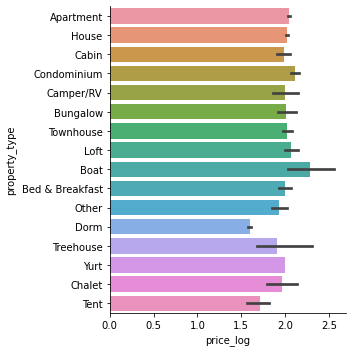

In [12]:
sns.catplot(y="property_type", x="price_log", data=listings, kind="bar", orient = "h")

7. Isolate the target variable in an object y and the other variables in an object X

In [13]:
X = listings.drop(labels = ["price","price2","price_log"], axis=1)
#X = avg_priced_dataset.drop(["price"], axis = 1)
y = listings.price_log

8. We will have to removea certain number of variables that we do not know how to use at this point. Start by removing the variables that could be interpreted as an ```id``` , we will also remove the variables that contain long texts as we haven't learned about text processing yet. 

We also have to remove all variables related to price, as they represent a risk of leak because of their direct link to the target variable, like ```monthly price```.

A certain number of variables contain a very high amount of missing values, in some cases these missing values correspond to an information we can exploit, sometimes not. Remove these not so useful variables from the dataset, strat by checking the proportion of missing values for all variables.

Your dataset should only contain categorical and numerical variables after this step. Check if your final dataset contains the following variables :

```
Index(['experiences_offered', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')
```

In [14]:
a=X.isnull().sum()/X.shape[0]*100
a.sort_values(ascending=False)

license                             100.000000
square_feet                          97.459403
monthly_price                        60.267156
security_deposit                     51.126244
weekly_price                         47.380828
notes                                42.063908
neighborhood_overview                27.029859
cleaning_fee                         26.977475
transit                              24.463070
host_about                           22.498690
host_acceptance_rate                 20.246202
review_scores_accuracy               17.234154
review_scores_checkin                17.234154
review_scores_value                  17.181771
review_scores_location               17.155579
review_scores_cleanliness            17.103195
review_scores_communication          17.050812
review_scores_rating                 16.946045
last_review                          16.422211
first_review                         16.422211
reviews_per_month                    16.422211
space        

In [15]:
X_clean = X.drop(["host_location", 
            "host_about", 
            "host_thumbnail_url", 
            "host_picture_url",
           "license",
           "monthly_price",
           "square_feet",
            #"host_verifications", 
        "street", 
        "neighbourhood", 
        "neighbourhood_cleansed", 
        "city", 
        "state", 
        "market", 
        "smart_location",
        "country_code",
        "country",
        #"is_location_exact",
        "amenities",
        "jurisdiction_names",
        "first_review",
        "last_review",
        "calendar_last_scraped",
        "weekly_price",
            "notes",
                  "neighborhood_overview",
         "name",
                  "description",
                  "listing_url" ,
"host_id",
"host_url",
                 "scrape_id",
                 "space",
                 "picture_url",
                 "last_scraped",
                 "host_name",
                 "medium_url",
                 "summary",
                 "xl_picture_url",
                 "transit",
                 "thumbnail_url",
                 "host_neighbourhood",
                 "zipcode",
                 "calendar_updated",
                 "license","id"], axis=1)

9 Are there any remaining missing values ? Is there a relevant way to replace those missing values without using imputing methods ? Are all the vairables in a numerical format ? If not run some preprocessing to create a clean dataset.

In [16]:
a=X_clean.isnull().sum()/X.shape[0]*100
a.sort_values(ascending=False)

security_deposit                    51.126244
cleaning_fee                        26.977475
host_acceptance_rate                20.246202
review_scores_checkin               17.234154
review_scores_accuracy              17.234154
review_scores_value                 17.181771
review_scores_location              17.155579
review_scores_cleanliness           17.103195
review_scores_communication         17.050812
review_scores_rating                16.946045
reviews_per_month                   16.422211
host_response_rate                  13.698271
host_response_time                  13.698271
bathrooms                            0.419068
bedrooms                             0.157150
host_has_profile_pic                 0.052383
host_total_listings_count            0.052383
host_listings_count                  0.052383
host_is_superhost                    0.052383
host_since                           0.052383
host_identity_verified               0.052383
property_type                     

In [17]:
# The cleaning fee variable needs to be converted to numerical format and the missing values replaced by 0, a missing value must mean no separated cleaning fees
X_clean.cleaning_fee = X_clean.cleaning_fee.apply(lambda x: float(x[1:])/100 if type(x) == str else x)
X_clean.cleaning_fee = X_clean.cleaning_fee.fillna(0)
X_clean.cleaning_fee

0       0.00
1       0.40
2       3.00
3       0.00
4       1.25
        ... 
3813    2.30
3814    0.50
3815    0.35
3816    0.45
3817    0.00
Name: cleaning_fee, Length: 3818, dtype: float64

In [18]:
# host_reponse_rate needs to be converted to numerical format
X_clean["host_response_rate_clean"] = X_clean.host_response_rate.apply(lambda x: float(x[:-1])/100 if type(x) == str else x)
X_clean = X_clean.drop("host_response_rate", axis =1)
X_clean["host_response_rate_clean"]

0       0.96
1       0.98
2       0.67
3        NaN
4       1.00
        ... 
3813    0.99
3814    1.00
3815     NaN
3816    1.00
3817    1.00
Name: host_response_rate_clean, Length: 3818, dtype: float64

In [19]:
X_clean["host_acceptance_rate_clean"] = X_clean.host_acceptance_rate.apply(lambda x: int(x[:-1])/100 if type(x) == str else x)
X_clean = X_clean.drop("host_acceptance_rate", axis = 1)
X_clean["host_acceptance_rate_clean"]

0       1.0
1       1.0
2       1.0
3       NaN
4       NaN
       ... 
3813    1.0
3814    1.0
3815    NaN
3816    NaN
3817    NaN
Name: host_acceptance_rate_clean, Length: 3818, dtype: float64

In [20]:
X_clean.security_deposit = X_clean.security_deposit.apply(lambda x: float(str(x).replace(",","").replace("nan","$0")[1:]))
X_clean.security_deposit = X_clean.security_deposit.fillna(0)
X_clean.security_deposit

0          0.0
1        100.0
2       1000.0
3          0.0
4        700.0
         ...  
3813       0.0
3814     500.0
3815     250.0
3816     300.0
3817       0.0
Name: security_deposit, Length: 3818, dtype: float64

In [21]:
X_clean.host_has_profile_pic = X_clean.host_has_profile_pic.fillna("f")
X_clean.host_has_profile_pic

0       t
1       t
2       t
3       t
4       t
       ..
3813    t
3814    t
3815    t
3816    t
3817    t
Name: host_has_profile_pic, Length: 3818, dtype: object

In [23]:
X_clean.host_identity_verified = X_clean.host_identity_verified.fillna("f")
X_clean.host_identity_verified

0       t
1       t
2       t
3       t
4       t
       ..
3813    t
3814    t
3815    f
3816    t
3817    t
Name: host_identity_verified, Length: 3818, dtype: object

In [24]:
X_clean.is_location_exact = X_clean.is_location_exact.fillna("f")
X_clean.is_location_exact

0       t
1       t
2       t
3       t
4       t
       ..
3813    t
3814    t
3815    f
3816    f
3817    t
Name: is_location_exact, Length: 3818, dtype: object

In [25]:
X_clean.host_response_time = X_clean.host_response_time.fillna("Unknown")
X_clean.host_response_time

0       within a few hours
1           within an hour
2       within a few hours
3                  Unknown
4           within an hour
               ...        
3813    within a few hours
3814        within an hour
3815               Unknown
3816        within an hour
3817          within a day
Name: host_response_time, Length: 3818, dtype: object

In [26]:
X_clean.host_is_superhost = X_clean.host_is_superhost.fillna("Unknown")
X_clean.host_is_superhost

0       f
1       t
2       f
3       f
4       f
       ..
3813    f
3814    f
3815    f
3816    f
3817    f
Name: host_is_superhost, Length: 3818, dtype: object

In [27]:
X_clean.property_type = X_clean.property_type.fillna("unknown")
X_clean.property_type

0         Apartment
1         Apartment
2             House
3         Apartment
4             House
           ...     
3813          House
3814      Apartment
3815          House
3816    Condominium
3817      Apartment
Name: property_type, Length: 3818, dtype: object

In [28]:
X_clean.extra_people = X_clean.extra_people.apply(lambda x: float(x[1:]))
X_clean.extra_people

0        5.0
1        0.0
2       25.0
3        0.0
4       15.0
        ... 
3813     0.0
3814    25.0
3815    20.0
3816     0.0
3817     0.0
Name: extra_people, Length: 3818, dtype: float64

In [29]:
X_clean["host_verifications_clean"] = X_clean.host_verifications.fillna("[]")
X_clean["host_verifications_clean"] = X_clean["host_verifications_clean"].apply(lambda x : x.replace("None","[]"))
X_clean["host_verifications_clean"] = X_clean["host_verifications_clean"].apply(lambda x: len(ast.literal_eval(x)))
X_clean = X_clean.drop("host_verifications", axis=1)
X_clean.host_verifications_clean

0       4
1       6
2       5
3       5
4       5
       ..
3813    5
3814    5
3815    1
3816    5
3817    4
Name: host_verifications_clean, Length: 3818, dtype: int64

In [30]:
X_clean.host_since = (pd.Timestamp("today") - pd.to_datetime(X_clean.host_since, format= "%Y-%m-%d"))
X_clean.host_since = X_clean.host_since.apply(lambda x: x.days)

X_clean.host_since

0       3905.0
1       3345.0
2       2869.0
3       3087.0
4       3795.0
         ...  
3813    2564.0
3814    2380.0
3815    2303.0
3816    2664.0
3817    2917.0
Name: host_since, Length: 3818, dtype: float64

10. Check that all variables that can can be converted are in numerical format, do not forget to check y as well.

In [31]:
X_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   experiences_offered               3818 non-null   object 
 1   host_since                        3816 non-null   float64
 2   host_response_time                3818 non-null   object 
 3   host_is_superhost                 3818 non-null   object 
 4   host_listings_count               3816 non-null   float64
 5   host_total_listings_count         3816 non-null   float64
 6   host_has_profile_pic              3818 non-null   object 
 7   host_identity_verified            3818 non-null   object 
 8   neighbourhood_group_cleansed      3818 non-null   object 
 9   latitude                          3818 non-null   float64
 10  longitude                         3818 non-null   float64
 11  is_location_exact                 3818 non-null   object 
 12  proper

11. Apply ```train_test_split``` to create an X_train X_test y_train and y_test objects

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size =0.2, random_state = 1)

12. Separate the variables into two groups, one for the numerical variables and one for the categorical variables. And normalize each subgroup of variables properly. You can refer yourself to the preprocessing exercise at the beginning ofthe module.

In [33]:
num_col = X_clean.select_dtypes([np.number]).columns
cat_col = X_clean.select_dtypes("object").columns

# Create pipeline for numeric features
numeric_features = X_clean.select_dtypes([np.number]).columns # numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = X_clean.select_dtypes("object").columns # categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder()) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)

# Preprocessings on test set
X_test = preprocessor.transform(X_test) # Don't fit again !!

13. It is now time to take care of the remaining missing values, apply the imputing method of your choice.

In [34]:
imputer = KNNImputer()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

14. What is the baseline score for your regression problem?

In [44]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
DummyRegressor()
dummy_regr.predict(X_train)
print(f"score baseline train {dummy_regr.score(X_train, y_train)}")
print(f"score baseline test {dummy_regr.score(X_test, y_test)}")

score baseline train 0.0
score baseline test -0.00014016020168972076


15. Train an Adaboost model with all its default parameters, what's the score ?


In [45]:

regressor_ada = AdaBoostRegressor()
regressor_ada.fit(X_train, y_train)

print("score Adaboost default train {}".format(regressor_ada.score(X_train, y_train)))
print("\n")
print("score Adaboost default test {}".format(regressor_ada.score(X_test, y_test)))

#np.sqrt(np.mean((regressor_ada.predict(X_test) - y_test.values)**2))

score Adaboost default train 0.665337465405262


score Adaboost default test 0.6617904218070274


16. Train an XGBoost model with all its default parameters except max_depth=3 (the same as adaboost default), what's the score ?


In [46]:

regressor_xgb = XGBRegressor(max_depth=3)
regressor_xgb.fit(X_train, y_train)

print("score XGBoost default train {}".format(regressor_xgb.score(X_train, y_train)))
print("\n")
print("score XGBoost default test {}".format(regressor_xgb.score(X_test, y_test)))


score XGBoost default train 0.8628868320012181


score XGBoost default test 0.740219257619316


17. Adaboost does not seem to be performing as well as XGBoost, however it does not seem to overfit the data as much, try and improve it by playing with its parameters ```learning rate``` & ```n_estimators``` thanks to a grid search

In [38]:
from sklearn.model_selection import GridSearchCV
regressor_ada = AdaBoostRegressor()
parameters = {'n_estimators':[50, 100, 150, 200],
              "learning_rate":[1.0, 0.5, 0.1]}

regressor_ada_best = GridSearchCV(regressor_ada, parameters)
regressor_ada_best.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [1.0, 0.5, 0.1],
                         'n_estimators': [50, 100, 150, 200]})

In [39]:
regressor_ada_best.best_params_

{'learning_rate': 1.0, 'n_estimators': 100}

In [40]:
ada_best_model = regressor_ada_best.best_estimator_
print("score Adaboost grid search train {}".format(ada_best_model.score(X_train, y_train)))
print("\n")
print("score Adaboost grid search test {}".format(ada_best_model.score(X_test, y_test)))

score Adaboost grid search train 0.669437135671672


score Adaboost grid search test 0.6666718088135654


We don't seem to be able to reach XGBoost performance using Adaboost in this case

18. Let's now run a sanity check to make sure that Adaboost and XGBoost actually improved the performance of their base models which are regression trees in this case. Train a regression tree model with max_depth = 3 (the default for Adaboost)

In [41]:
from sklearn.tree import DecisionTreeRegressor
tree_regressor = DecisionTreeRegressor(max_depth=3)
tree_regressor.fit(X_train, y_train)

print("score Tree max depth 3 train {}".format(tree_regressor.score(X_train, y_train)))
print("\n")
print("score Tree max depth 3 test {}".format(tree_regressor.score(X_test, y_test)))

score Tree max depth 3 train 0.5886432657850099


score Tree max depth 3 test 0.6034566813369954


We conclude here that both boosting algorithms have fulfilled their missions, they both were able to improve performance on the test set compared to the base model! However XGBoost seems to have superior performance in this case despite higher levels of over fitting